<a href="https://colab.research.google.com/github/peterbabulik/QuantumAI/blob/main/ZNEthan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qiskit qiskit-ibm-runtime -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.3 MB/s eta 0:00:00


qiskit_runtime_service._discover_account:WARNING:2026-02-05 23:12:55,073: Loading account with the given token. A saved account will not be used.


--- 1. PREPARING CUSTOM ZNE (Tanh Fit) ON ibm_torino ---


qiskit_runtime_service.__init__:WARNING:2026-02-05 23:12:59,346: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-05 23:12:59,347: Using instance: open-instance, plan: open
/tmp/ipython-input-1925940505.py:31: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, e

Transpiling...
--- 2. SUBMITTING JOB (Noise Factors: [1, 3, 5]) ---
Job ID: d62i7vrc4tus73fdge7g
Waiting for completion...

--- 3. RAW DATA FROM QUANTUM COMPUTER ---
Noise Factor 1.0x : Expectation = 0.32216
Noise Factor 3.0x : Expectation = 0.19558
Noise Factor 5.0x : Expectation = 0.09134

--- 4. FITTING CUSTOM TANH MODEL ---
Model Parameters: a=0.3899, b=-0.5170, c=0.1317
>> Extrapolated Value (x=0): 0.38987
>> Standard Linear Value     : 0.37615


/tmp/ipython-input-1925940505.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(tanh_decay_model, NOISE_FACTORS, raw_evs, p0=[-0.2, 0.1, 0.5], maxfev=5000)



Plot saved to 'zne_tanh_analysis.png'


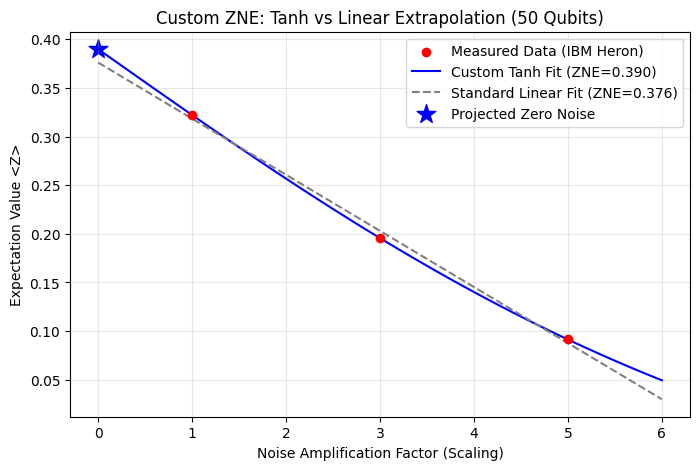

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, EstimatorOptions

# --- CONFIGURATION ---
API_KEY = "your api here"
BACKEND_NAME = "ibm_torino"
NUM_QUBITS = 50
SHOTS = 4096
NOISE_FACTORS = [1, 3, 5]  # We measure at these noise levels

# --- DEFINING YOUR CUSTOM MODEL ---
# User Request: Tanh Extrapolation
# Logic: We model the decay of signal as a tanh function of noise level (x)
# f(x) = a + b * tanh(c * x)
# At x=0 (Zero Noise), the value is 'a'.
def tanh_decay_model(x, a, b, c):
    return a + b * np.tanh(c * x)

def run_custom_zne():
    print(f"--- 1. PREPARING CUSTOM ZNE (Tanh Fit) ON {BACKEND_NAME} ---")

    service = QiskitRuntimeService(channel="ibm_quantum_platform", token=API_KEY)
    backend = service.backend(BACKEND_NAME)

    # 1. Circuit (Same as before for consistency)
    feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, entanglement='linear')
    ansatz = EfficientSU2(num_qubits=NUM_QUBITS, reps=1, entanglement='linear')
    circuit = feature_map.compose(ansatz)

    print("Transpiling...")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    isa_circuit = pm.run(circuit)

    observable = SparsePauliOp(["I" * (NUM_QUBITS - 1) + "Z"])
    isa_observable = observable.apply_layout(isa_circuit.layout)

    # 2. Data
    np.random.seed(42)
    full_params = np.random.uniform(0, 2*np.pi, circuit.num_parameters)

    # 3. Configure Runtime to return RAW NOISE DATA
    options = EstimatorOptions()
    options.default_shots = SHOTS
    options.resilience_level = 2
    options.resilience.zne_mitigation = True
    options.resilience.zne.noise_factors = NOISE_FACTORS
    # We set a dummy extrapolator because we will ignore it and do our own
    options.resilience.zne.extrapolator = "linear"

    print(f"--- 2. SUBMITTING JOB (Noise Factors: {NOISE_FACTORS}) ---")
    estimator = Estimator(mode=backend, options=options)

    # Run
    job = estimator.run([(isa_circuit, [isa_observable], [full_params])])
    print(f"Job ID: {job.job_id()}")
    print("Waiting for completion...")
    result = job.result()

    # --- 4. EXTRACT RAW DATA FOR CUSTOM FITTING ---
    # Qiskit V2 returns the expectation values at each noise factor in 'evs_noise_factors'
    # Shape is usually (1, 1, num_factors) -> we flatten it
    raw_evs = result[0].data.evs_noise_factors[0].flatten()

    print("\n--- 3. RAW DATA FROM QUANTUM COMPUTER ---")
    for nf, ev in zip(NOISE_FACTORS, raw_evs):
        print(f"Noise Factor {nf:.1f}x : Expectation = {ev:.5f}")

    # --- 5. PERFORM CUSTOM TANH EXTRAPOLATION ---
    print("\n--- 4. FITTING CUSTOM TANH MODEL ---")

    try:
        # Fit the data to: a + b * tanh(c * x)
        # Initial guess (p0) helps convergence:
        # a (intercept) ~ value at noise 1
        # b (scale) ~ -0.1 (decaying)
        # c (rate) ~ 0.5
        popt, pcov = curve_fit(tanh_decay_model, NOISE_FACTORS, raw_evs, p0=[-0.2, 0.1, 0.5], maxfev=5000)

        # The Zero Noise Limit is f(0)
        # f(0) = a + b*tanh(0) = a
        zne_limit_tanh = popt[0]

        print(f"Model Parameters: a={popt[0]:.4f}, b={popt[1]:.4f}, c={popt[2]:.4f}")
        print(f">> Extrapolated Value (x=0): {zne_limit_tanh:.5f}")

        # Compare with Linear (Standard Qiskit)
        # We can calculate linear fit manually to compare
        slope, intercept = np.polyfit(NOISE_FACTORS, raw_evs, 1)
        zne_limit_linear = intercept

        print(f">> Standard Linear Value     : {zne_limit_linear:.5f}")

        # --- 6. PLOT FOR THE PAPER ---
        plt.figure(figsize=(8, 5))

        # Plot Data Points
        plt.scatter(NOISE_FACTORS, raw_evs, color='red', label='Measured Data (IBM Heron)', zorder=5)

        # Plot Fits
        x_range = np.linspace(0, 6, 100)
        plt.plot(x_range, tanh_decay_model(x_range, *popt), label=f'Custom Tanh Fit (ZNE={zne_limit_tanh:.3f})', color='blue')
        plt.plot(x_range, slope*x_range + intercept, label=f'Standard Linear Fit (ZNE={zne_limit_linear:.3f})', color='gray', linestyle='--')

        # Formatting
        plt.scatter([0], [zne_limit_tanh], color='blue', marker='*', s=200, label='Projected Zero Noise')
        plt.xlabel('Noise Amplification Factor (Scaling)')
        plt.ylabel('Expectation Value <Z>')
        plt.title('Custom ZNE: Tanh vs Linear Extrapolation (50 Qubits)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig("zne_tanh_analysis.png")
        print("\nPlot saved to 'zne_tanh_analysis.png'")

    except Exception as e:
        print(f"Fitting failed: {e}")
        print("Tip: If data is too noisy, Tanh fitting might be unstable. Try collecting more shots.")

if __name__ == "__main__":
    run_custom_zne()